This notebook shows a possible polynomial fit to the DR16 RGB stars and a comparison to the Bayesian analysis from Diane

In [10]:
##############################
### Import the usual stuff ###
##############################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u


import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms

from uncertainties import ufloat

from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm


# find distance based on position of stars in LMC 
def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

$$

In [11]:
###################
### Import Data ###
###################

'''
Logiso = PARSEC
lmcdr16 = DR 16 RGB stars
pdfout = pdf from Diane
origin = other file from Diane
'''

logiso = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', format='basic', delimiter='\s')
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers.dr16beta.fits',1) #APOGEE data
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits' , 1)
origin = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/output_LMC_DR16_all.fits', 1)

#pick out only RGB stars in the PARSEC isochrones
rgb = np.where(logiso['label']==3)


In [12]:
#################################
### Possible Polynomial Model ###
#################################

'''
This is the model fit to create the polynomial fit:

[logteff,Ks,feh,logg,np.multiply(glogteff,gKs),np.multiply(logteff,feh),np.multiply(glogteff,glogg),
np.multiply(gKs,glogg),logteff**2,Ks**2,logg**2]

'''


def model(x1,x2,x3,x4):
    p = [4.52271170e+02,-2.45756963e+02,1.23004992e+00,-8.43079619e-01,1.50107300e+01,5.55614699e-01,2.33494763e-01,-6.40147708e+00,-6.73945112e-01,3.53816153e+01,1.33852966e-01,9.73455106e-01]
    out = p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*x1*x2+p[6]*x1*x3+p[7]*x1*x4+p[8]*x2*x4+p[9]*x1**2+p[10]*x2**2+p[11]*x4**2 
    return out

$a + b\log{T_{eff}} + cK_{s} + d[Fe/H] + f\log{g} + \\g(\log{T_{eff}})K_s + h(\log{T_{eff}})[Fe/H] + k(\log{T_{eff}})\log{g} +\\ l(\log{g})K_s + m\log^2{T_{eff}} + nK_{s}^2 + p\log^2{g}$

In [13]:
################################################
### Get Absolute Magnitude and Calculate age ###
################################################

#get distances and pick out where [Fe/H] and the extinction are good values
stardist = dist2LMCtest(lmcdr16['RA'],lmcdr16['DEC'],82.36271032823551, -69.73662459779977, 148.78306172598795, 25.856372265418806)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0))

#calculate the absolute magnitude and get age
corabsK = absmag(lmcdr16[clnr]['K'],stardist[clnr],False)-lmcdr16[clnr]['AK_TARG']
modage = model(np.log10(lmcdr16[clnr]['TEFF']),corabsK,lmcdr16[clnr]['FE_H'],lmcdr16[clnr]['LOGG'])

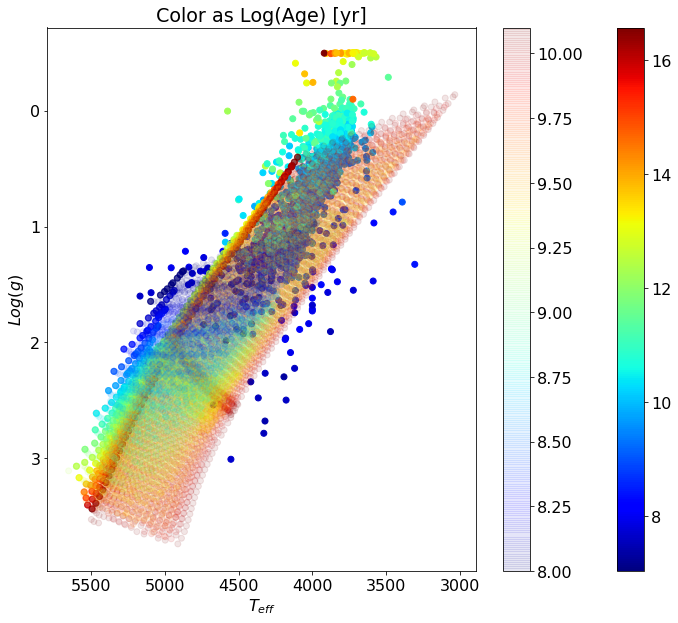

In [19]:
###############################
### Polynomial Fit for Ages ###
###############################

'''
Here is a plot that show both the PARSEC isochrones and the actual data color coded by the Log(Age).
The less transparent dots are the DR16 stars while the others are from PARSEC. The transparency was to
make it easier to see all the points. 

There seems to be issues with some of the stars with low Log(g).
'''

plt.figure(figsize=[12,10])
plt.scatter(lmcdr16[clnr]['TEFF'],lmcdr16[clnr]['LOGG'],c=modage,cmap='jet')
plt.colorbar()
plt.scatter(10**logiso[rgb]['logTe'],logiso[rgb]['logg'],c=logiso[rgb]['logAge'],cmap='jet',alpha=0.1)
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'$Log(g)$')
plt.title(r'Color as Log(Age) [yr]')
plt.savefig('CMDages.pdf',bbox_inches='tight')
plt.show()

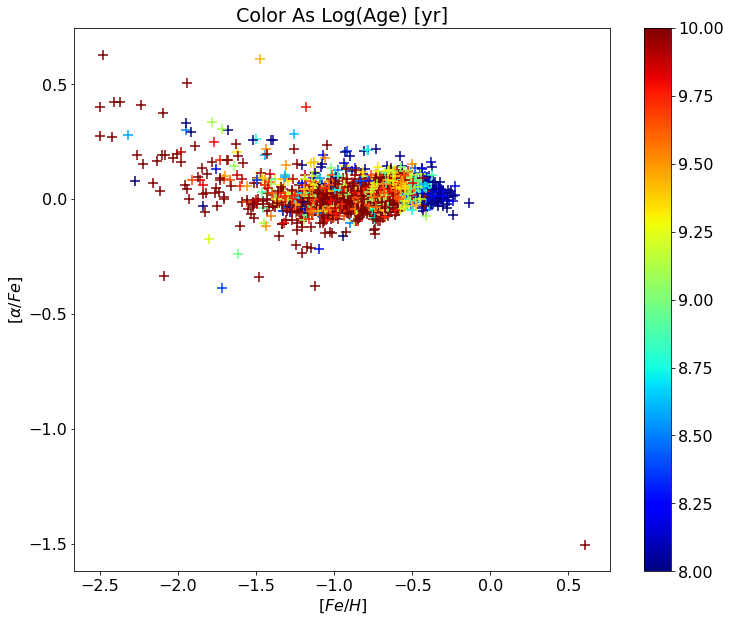

In [20]:
###########################################
### Alpha-Metallicity Plot (Polynomial) ###
###########################################

'''
This plot uses the exact same ages as before but normalizes the color to correspond to what the ages should be.
'''

plt.figure(figsize=[12,10])
plt.scatter(lmcdr16['FE_H'][clnr],\
            np.subtract(np.add(lmcdr16['ALPHA_M'][clnr],lmcdr16['M_H'][clnr]),lmcdr16['FE_H'][clnr]),\
           c=modage,marker='+',s=100,cmap='jet',vmax=10.0,vmin=8.0)
plt.colorbar()
plt.xlabel(r'$[Fe/H]$')
plt.ylabel(r'$[\alpha/Fe]$')
plt.title(r'Color As Log(Age) [yr]')
plt.savefig('alphaFeage.pdf',bbox_inches='tight')
plt.show()

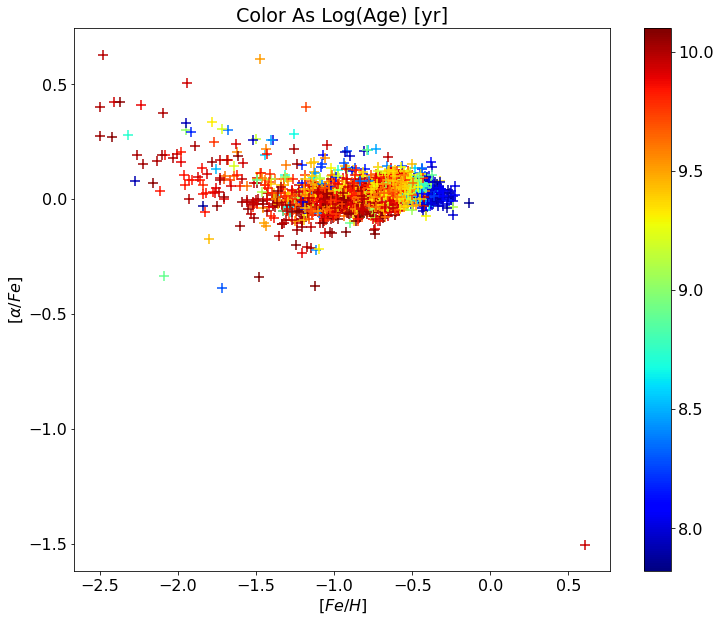

In [21]:
####################################
### Alpha-Metallicity (Bayesian) ###
####################################

'''
This plot is essentially the same plot in the email thread created by David using Diane's ages.
'''

cln = np.where((origin['FE_H']!=-9999)&(pdfout['P_MEAN']>-90))

plt.figure(figsize=[12,10])
plt.scatter(origin['FE_H'][cln],\
            np.subtract(np.add(origin['ALPHA_M'][cln],origin['M_H'][cln]),origin['FE_H'][cln]),\
           c=pdfout['P_MEAN'][cln],marker='+',s=100,cmap='jet')
plt.colorbar()
plt.xlabel(r'$[Fe/H]$')
plt.ylabel(r'$[\alpha/Fe]$')
plt.title(r'Color As Log(Age) [yr]')
plt.savefig('AlphaFeage_Diane.pdf',bbox_inches='tight')
plt.show()

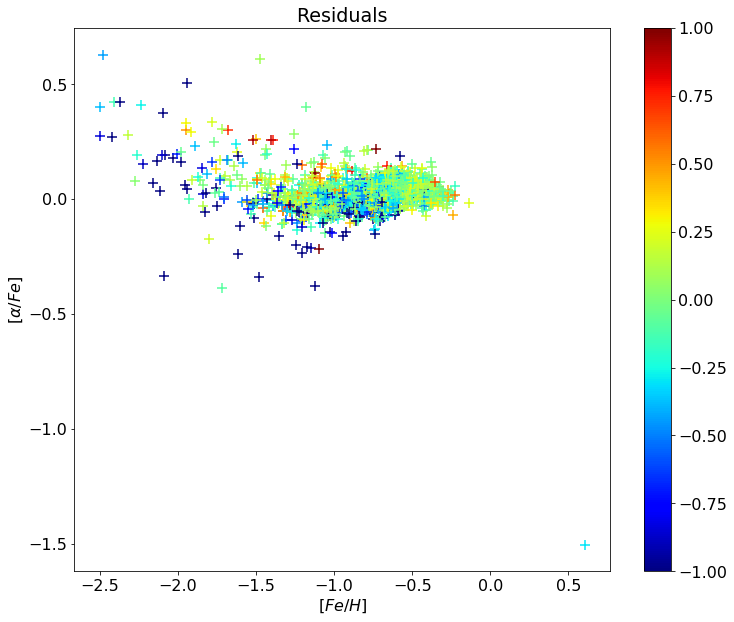

In [23]:
################################################
### Difference between Polynomianl and Bayes ###
################################################

'''
This plot show the difference between the two methods, but only looking at values between -1 and 1. There are
113 stars that differ more than +/-1.
'''

diff = np.subtract(pdfout['P_MEAN'][clnr],modage)

plt.figure(figsize=[12,10])
plt.scatter(lmcdr16['FE_H'][clnr],\
            np.subtract(np.add(lmcdr16['ALPHA_M'][clnr],lmcdr16['M_H'][clnr]),lmcdr16['FE_H'][clnr]),\
           c=diff,marker='+',s=100,cmap='jet',vmax=1,vmin=-1)
plt.colorbar()
plt.xlabel(r'$[Fe/H]$')
plt.ylabel(r'$[\alpha/Fe]$')
plt.title(r'Residuals')
plt.savefig('diffmethods.pdf',bbox_inches='tight')
plt.show()

In [18]:
################################
### Deviation for Difference ###
################################

'''
This is just the MAD for the difference between the two methods converted to stdev 
'''

np.median(np.absolute(diff-np.median(diff)))*1.4826

0.2722020380728524